In [1]:
%matplotlib inline 
import torch 
import torch.nn as nn
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt

from pyvi.utils import GMMLossFunc as lf
from pyvi.utils import HelperFunc as hf


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

print(f"Using {device} device")

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


# 1. Gaussian mixture state-space model

We consider a simple one-dimensional Gaussian mixture state process:
\begin{align*}
    y_t|x_t &\sim \mathcal{N}(x_t, \sigma_\epsilon^2), \\
    x_t|x_{t-1} &\sim w_t \mathcal{N}(x_{t-1}, \sigma_{\eta_1}^2) + (1-w_t) \mathcal{N}(x_{t-1}, \sigma_{\eta_2}^2),\: t=2,\dots, T,\\
    x_1 &\sim w_1 \mathcal{N}(1, \sigma_{\eta_1}^2) + (1 - w_1)\mathcal{N}(1, \sigma_{\eta_2}^2), \\
    w_t &\sim \text{Bernoulli}(p), \: t=1, 2, \dots, T,
\end{align*}

where $p \in [0,1]$ denotes the probability of selecting each mixture component of the state distribution. The model parameters are $\mathbf{\theta} = (p, \sigma_{\eta_1}^2, \sigma_{\eta_2}^2, \sigma_{\epsilon}^2)$.

## 1.1. Simulator

In [2]:
# simulator
def gaussian_mixture(theta: torch.Tensor, T=100) -> torch.Tensor:
    '''
    Simulates from a Gaussian mixture state-space model
    '''
    # simulate hidden state
    w = D.Bernoulli(probs=theta[...,0]).sample((T,)).T
    x = torch.zeros_like(w)

    x[...,0] = w[...,0] * D.Normal(torch.ones_like(theta[...,1]),
                                                      torch.sqrt(theta[...,1])).sample() +\
     (1 - w[...,0]) * D.Normal(torch.ones_like(theta[...,2]),
                                                  torch.sqrt(theta[...,2])).sample()
    
    for t in range(1,T):
        x[...,t] = w[...,t] * D.Normal(x[...,t-1], torch.sqrt(theta[...,1])).sample() +\
     (1 - w[...,t]) * D.Normal(x[...,t-1], torch.sqrt(theta[...,2])).sample()
    
    # simulate observables
    y = D.Normal(x.T, torch.sqrt(theta[...,3])).sample()

    return y.T

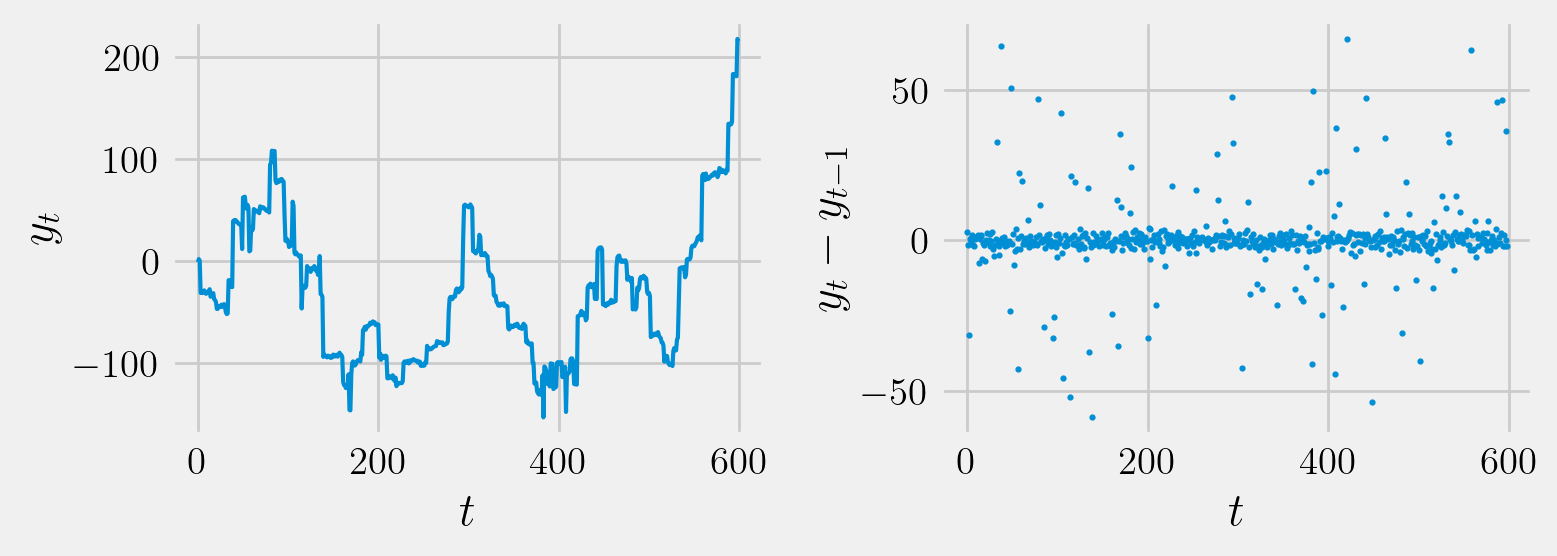

In [3]:
# model 1
theta = torch.tensor([[0.8, 1.0, 700.0, 1.0]])
T = 600

y = gaussian_mixture(theta, T).squeeze()

fig = plt.figure(figsize=(8,3), dpi=200)

fig.add_subplot(121)
plt.plot(torch.arange(T), y, lw=1.5)
plt.xlabel(r'$t$')
plt.ylabel(r'$y_t$')

fig.add_subplot(122)
plt.scatter(torch.arange(T-1), y[1:] - y[:(len(y)-1)], s=3.)
plt.xlabel(r'$t$')
plt.ylabel(r'$y_t - y_{t-1}$')

plt.tight_layout()
plt.show()

# 1.2. Parameter priors

\begin{align*}
    p &\sim U(0,1),\\
    \sigma_{\eta_1}^2 &\sim \Gamma^{-1}(2,2),\\
    \sigma_{\eta_2}^2 &\sim \Gamma^{-1}(2, 700),\\
    \sigma_\epsilon^2 &\sim \Gamma^{-1}(2,2)
\end{align*}

In [4]:
class InverseGammaUniform():
    def __init__(self, params_p, params_sigma2_1, params_sigma2_2, params_sigma2_eps):
        self.params = {'p':params_p, 'sigma2_eta1':params_sigma2_1,
                       'sigma2_eta2':params_sigma2_2, 'sigma2_epsilon':params_sigma2_eps}
        
        self.p = D.Uniform(low=self.params['p']['lower'], 
                                             high=self.params['p']['upper'])
        
        self.sigma2_eta1 = D.InverseGamma(self.params['sigma2_eta1']['alpha'],
                                                                          self.params['sigma2_eta1']['beta'])
        
        self.sigma2_eta2 = D.InverseGamma(self.params['sigma2_eta2']['alpha'],
                                                                          self.params['sigma2_eta2']['beta'])
        
        self.sigma2_epsilon = D.InverseGamma(self.params['sigma2_epsilon']['alpha'],
                                                                          self.params['sigma2_epsilon']['beta'])
        
    def sample(self, shape: torch.Size = ()):
        theta = torch.stack([self.p.sample(shape),
                            self.sigma2_eta1.sample(shape),
                            self.sigma2_eta2.sample(shape),
                            self.sigma2_epsilon.sample(shape)
                            ], dim=-1)
        
        # fix last 2 parameters
        #theta[:,2] = 700.0
        #theta[:,3] = 0.1
       
        
        return theta
        
    def log_prob(self, theta):
        logprob = self.p.log_prob(theta[...,0]) + self.sigma2_eta1.log_prob(theta[...,1]) +\
        self.sigma2_eta2.log_prob(theta[...,2]) + self.sigma2_epsilon.log_prob(theta[...,3])

        return logprob


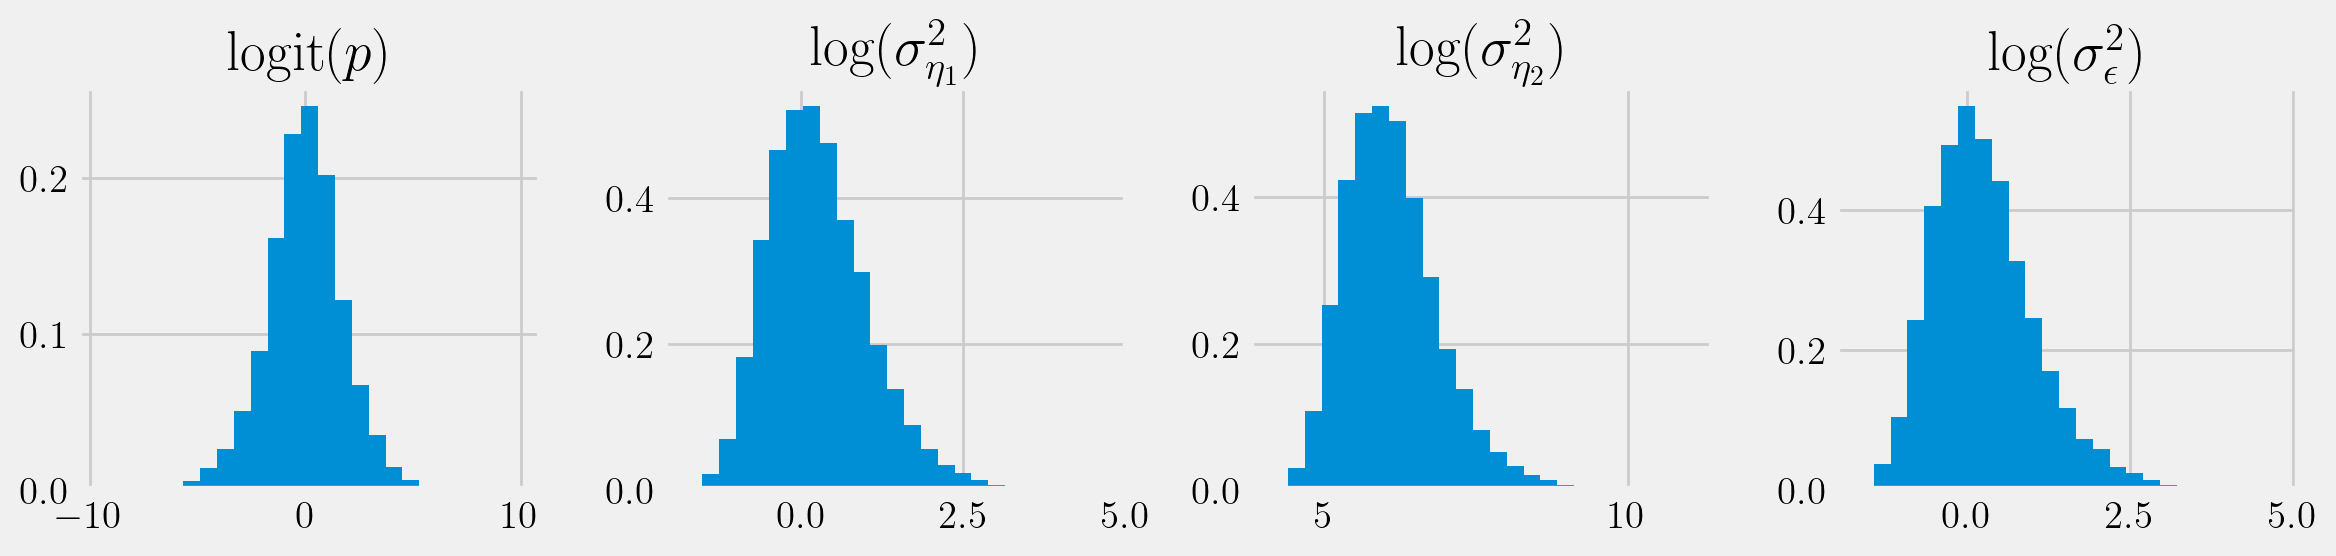

In [5]:
p = {'lower': 0.0, 'upper': 1.0}
sigma2_1 = {'alpha': 2.0, 'beta': 2.0}
sigma2_2 = {'alpha': 2.0, 'beta': 700.0}
sigma2_eps = {'alpha': 2.0, 'beta': 2.0}

prior = InverseGammaUniform(p, sigma2_1, sigma2_2, sigma2_eps)
N = 10000
theta =  prior.sample((N,))

fig = plt.figure(figsize=(12, 3), dpi=200)

fig.add_subplot(141)
plt.hist(theta[...,0].logit(), bins=25, density=True)
plt.title(r'$\mathrm{logit}(p)$')

fig.add_subplot(142)
plt.hist(theta[...,1].log(), bins=25, density=True)
plt.title(r'$\log(\sigma_{\eta_1}^2) $')

fig.add_subplot(143)
plt.hist(theta[...,2].log(), bins=25, density=True)
plt.title(r'$\log(\sigma_{\eta_2}^2) $')

fig.add_subplot(144)
plt.hist(theta[...,3].log(), bins=25, density=True)
plt.title(r'$\log(\sigma_{\epsilon}^2) $')

plt.tight_layout()
plt.show()

## 1.3. Neural Varitional inference: Training the Neural Net

In [6]:
class LSTMNet(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64, num_hd=1):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 

        # lstm layer
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=120, num_layers=num_hd, batch_first=True)

        # fully connected hidden layer
        self.fc = nn.Sequential(
            nn.Linear(120, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):
        # lstm & hidden layers
        x, _ = self.lstm(x)
        x = x[:,-1,:]   # extract final time step
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
    

def transform_data(data, period_length, stride=None, diff=False, sort=False):
    if not stride:
        stride = period_length

    dataset = data.clone()

    if diff:
        dataset = dataset[...,1:] - dataset[...,:-1]
    if sort:
        dataset = dataset.sort(dim=-1).values
    
    Y = []
    stop = False
    i = 0
    while not stop:
        period = dataset[...,i:(i + period_length)]
        Y.append(period)
        i += stride

        stop = (dataset.size(1) < (i + period_length))
    
    return torch.stack(Y, dim=1)


        

### Training

Epoch 10 Loss 5.090396389865875 

Epoch 20 Loss 4.839953924679756 

Epoch 30 Loss 4.702833545827866 

Epoch 40 Loss 4.607121052217484 

Epoch 50 Loss 4.520138054919243 

Epoch 60 Loss 4.4479348439216615 

Epoch 70 Loss 4.381098376882076 

Epoch 80 Loss 4.327072783112526 

Epoch 90 Loss 4.269364989167451 

Epoch 100 Loss 4.214839215430617 

Epoch 110 Loss 4.17192383789022 

Epoch 120 Loss 4.129564632457495 

Epoch 130 Loss 4.102213854882866 

Epoch 140 Loss 4.059658576332778 

Epoch 150 Loss 4.028226840541605 

Epoch 160 Loss 3.9960061886266804 

Epoch 10 Loss 5.025203586173058 

Epoch 20 Loss 4.419522935461998 

Epoch 30 Loss 4.041680675983429 

Epoch 40 Loss 3.690477350628376 

Epoch 50 Loss 3.4371815568223596 

Epoch 60 Loss 3.2592665371224285 

Epoch 70 Loss 3.129763272130862 

Epoch 10 Loss 3.2199131456423085 

Epoch 20 Loss 2.660067337979097 

Epoch 30 Loss 2.4286126524624008 

Epoch 40 Loss 2.0775706446342594 

Epoch 50 Loss 1.9591061830002698 

Epoch 60 Loss 1.8747176675394934 


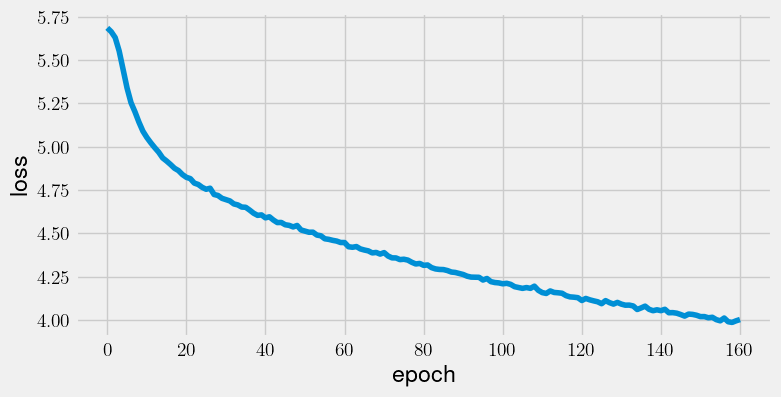

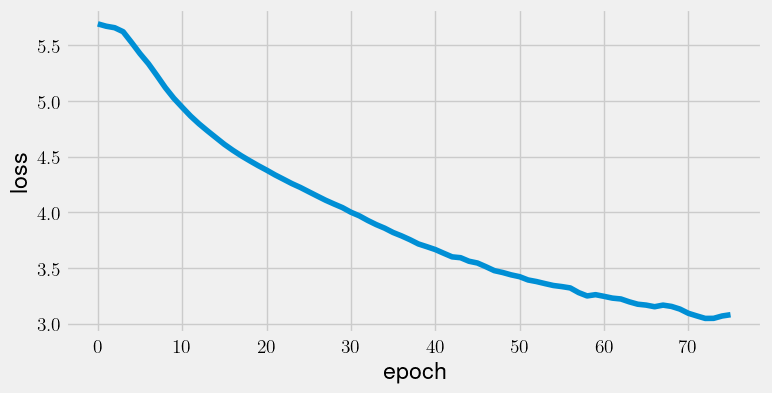

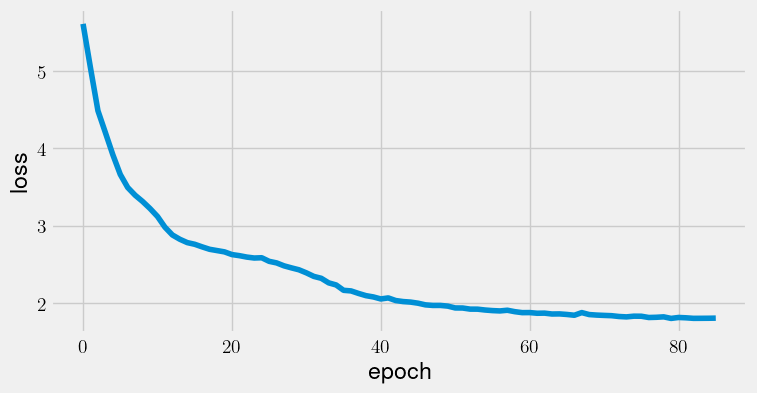

In [7]:
#Explicitly provided seeds for training process
random_seed = 1234
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, period_length, stride, batchsize = 10000, 200, 20, 3, 200

# sample parameter values from the specified prior
Theta_train =  prior.sample((n_prior,))

# draw samples from the simulator conditioned on parameter values
Y_train = gaussian_mixture(Theta_train, n_obs)
Y_train_raw = transform_data(Y_train, period_length=period_length, diff=False, sort=False)
Y_train_diff = transform_data(Y_train, period_length=period_length, diff=True, sort=False)
Y_train_diff_sort = transform_data(Y_train, period_length=period_length, diff=True, sort=True)

# put all the sigma2 on log-scale for improved training
Theta_train[:,0] = Theta_train[:,0].logit()
Theta_train[:,1:] = Theta_train[:,1:].log()

# remove observation variance
#Theta_train = Theta_train[...,:3]
# standardize parameters
mean_param, std_param =  Theta_train.mean(dim=0), Theta_train.std(dim=0)
Theta_train = (Theta_train - mean_param) / std_param

for k in range(3):
    # create a combined dataset and data loader
    if k==0:
        data_train = torch.utils.data.TensorDataset(Y_train_raw, Theta_train)
        path = 'trained_models/gmss/gmss_lstm_raw.pt'
    if k==1:
        data_train = torch.utils.data.TensorDataset(Y_train_diff, Theta_train)
        path = 'trained_models/gmss/gmss_lstm_diff.pt'
    if k==2:
        data_train = torch.utils.data.TensorDataset(Y_train_diff_sort, Theta_train)
        path = 'trained_models/gmss/gmss_lstm_diffsort.pt'
    data_loader = torch.utils.data.dataloader.DataLoader(data_train, batch_size=batchsize, shuffle=True)


    gmmnet = LSTMNet(input_size=period_length, dim=4, K=2, hd=128, num_hd=1).to(device)
    loss_fn = lf.GaussianMixtureLoss(aggr='mean')

    # # train DNN model
    gmmnet = hf.nn_optimizer(model=gmmnet, 
                        data_loader=data_loader,
                        loss_fn=loss_fn,
                        learning_rate=1e-4,
                        eps=0.001, 
                        max_epochs=400,
                        verbose=True,
                        echo_after=10,
                        path=path
                        )

#gmmnet = torch.load('trained_models/gmss/gmss_lstm.pt')

### Posterior distribution

In [21]:
theta = torch.tensor([[0.8, 2.0, 700.0, 1.]])
#theta = prior.sample((1,))
T = n_obs

ysim = gaussian_mixture(theta, T)

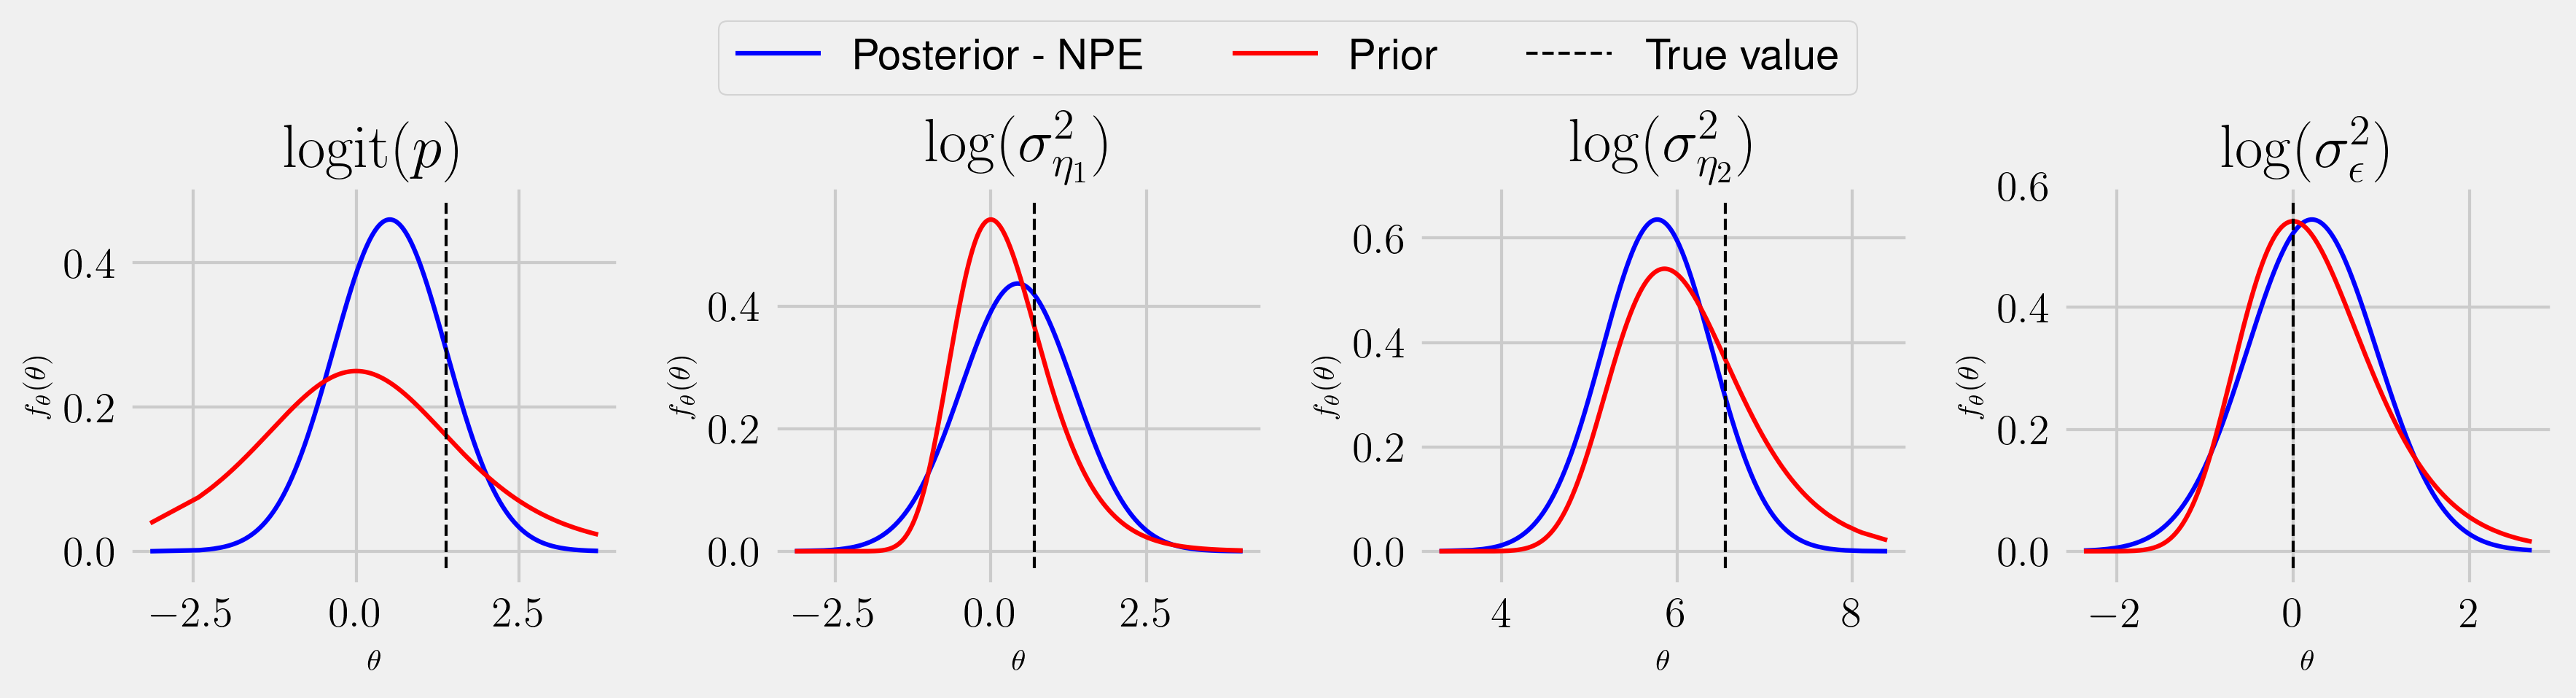

In [24]:
y = transform_data(ysim, period_length=period_length, diff=False, sort=False)
gmmnet = torch.load('trained_models/gmss/gmss_lstm_raw.pt')

# run the gmmnet
with torch.no_grad():
    mean, chol, coeff = gmmnet(y.to(device))

n_sim, n_component, dim = mean.shape[0], mean.shape[1], mean.shape[2]

# calculate Cholesky factors
chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

# # caclulate precision matrices
precision = chol @ chol.transpose(2, 3)

# # calculate covariance matrices
covariance = torch.linalg.inv(precision) 

# mixture weights
mix = D.Categorical(coeff)


# plotting
fig = plt.figure(figsize=(12, 3), dpi=300)

labels = [r'$\mathrm{logit}(p)$', r'$\log(\sigma_{\eta_1}^2) $', r'$\log(\sigma_{\eta_2}^2) $', r'$\log(\sigma_{\epsilon}^2) $']
for k in range(dim):
    # mixture components
    comp = D.Normal(loc=mean[:,:,k], scale=torch.sqrt(covariance[:,:,k,k]))
    # define the mixture
    gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,k].squeeze(), torch.sqrt(covariance[:,:,k,k]).squeeze())

    # draw samples from the approximate posterior
    N = 10000
    # theta_k = gmm.sample((N,)).squeeze().sort().values 
    # pdf = gmm.log_prob(theta_k).exp().cpu()
    # theta_k = theta_k.cpu()

    # draw samples from the approximate posterior
    theta_k_sd = gmm.sample((N,)).squeeze().sort().values 
    theta_k = (theta_k_sd * std_param[k] + mean_param[k]).cpu().sort().values      # put on unnormalized scale
    pdf = gmm.log_prob(theta_k_sd).exp().cpu() / std_param[k]
    
    # prior
    if k == 0:
        theta_inv = theta_k.sigmoid()
        pdf_prior = prior.p.log_prob(theta_inv).exp() * abs(theta_inv * (1 - theta_inv))
    elif k == 1:
        theta_inv = theta_k.exp()
        pdf_prior = prior.sigma2_eta1.log_prob(theta_inv).exp() * abs(theta_inv)
    elif k == 2:
        theta_inv = theta_k.exp()
        pdf_prior = prior.sigma2_eta2.log_prob(theta_inv).exp() * abs(theta_inv)
    else:
        theta_inv = theta_k.exp()
        pdf_prior = prior.sigma2_epsilon.log_prob(theta_inv).exp() * abs(theta_inv)

    # true value    
    theta_k_true = theta[:,k].logit() if k == 0 else theta[:,k].log()
    
    fig.add_subplot(1, dim, k+1)
    plt.plot(theta_k, pdf, lw=1.5, c='b', label='Posterior - NPE')
    plt.plot(theta_k, pdf_prior, lw=1.5, c='r', label='Prior')
    plt.vlines(x=theta_k_true, ymin=plt.axis()[2], ymax=plt.axis()[3], linestyles='dashed', colors='black', lw=1, label='True value')
    
    plt.xlabel(r'$\theta$', fontsize=10)
    plt.ylabel(r'$f_\theta(\theta)$', fontsize=10)
    plt.title(labels[k])

handles, legend_labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True)
plt.tight_layout()
plt.show()

fig.savefig(fname="figures/gmss_noisy_raw.png", transparent=True, bbox_inches='tight')

### Simulation-based calibration check

In [99]:
def sbc_gaussian(gmmnet, proposal, n_sim = 1e+4, ecdf=True, ecdf_diff=False, logscale=None):
    '''
    Perform simulation-based calibration check for a Gaussian mixture network for posterior approximation

    Input:
        -- gmmnet: Gaussian mixture network, with input size given by `sample_size`
        -- proposal: proposal distribution `theta ~ p(theta)`, usually the same as the prior/proposal distribution used for training
                     Note: must have a `sample()` method
        
        -- generator: function that takes parameter values `theta` as input and generate the corresponding simulator model
                       `x ~ p(x|theta)`  as an instance of a class with a `sample` method
        
        -- sample_size: number of iid samples from `x ~ p(x|theta)` for each values of theta

        -- n_sim: number of simulation from the joint distribution: theta ~ p(theta); x ~ p(x|theta)

        -- ecdf: whether to output an eCDF or a histogram plot, default: ecdf=True

        -- ecdf_diff: whether on the y-axis are the `ecdf(w)` values (if True) or `ecdf(w) - w` values (if False).
                        This is ignored if ecdf=False.
        
        -- logscale: (iterable) contains dimensions of the model parameter vector `theta` that are on log-scale
                        note: we use the standard Python counting, starting at 0

    Note: 95% confidence intervals are based on the  Dvoretzky–Kiefer–Wolfowitz inequality (see https://en.wikipedia.org/wiki/Empirical_distribution_function, accessed: 20-05-2024)
    
    Output: SBC plot as a Pyplot figure
    '''

    # draw samples from the prior/proposal  theta ~ p(theta)
    Theta = proposal.sample((n_sim,))

    # draw samples from the model x ~ p(x|theta)
    X = gaussian_mixture(Theta, n_obs)
    X = transform_data(X, period_length=period_length)
    
    # ensure all dimensions are on the right scale
    Theta[:,0] = Theta[:,0].logit()

    if logscale:
        for i in logscale:
            Theta[:,i] = Theta[:,i].log()     # put sigma2 on logscale
            
    #Theta = Theta[...,:3]
    Theta =  (Theta - mean_param) / std_param
    
    # run the gmmnet
    with torch.no_grad():
        mean, chol, coeff = gmmnet(X.to(device))

    n_component, dim = mean.shape[1], mean.shape[2]

    # calculate Cholesky factors
    chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

    # caclulate precision matrices
    precision = chol @ chol.transpose(2, 3)

    # calculate covariance matrices
    covariance = torch.linalg.inv(precision) 

    # define GMM variational marginal distributions and calculate cdf values for the true parameter values
    W = torch.zeros((n_sim, dim))   # tensor of cdf values
    
    for j in range(dim):
        # mixture weights
        mix = D.Categorical(coeff)
        # mixture components
        comp = D.Normal(mean[:,:,j], torch.sqrt(covariance[:,:,j,j]))
        # define the mixture
        gmm = D.MixtureSameFamily(mix, comp)
        # evaluate cdf
        W[:,j] = gmm.cdf(Theta[:,j].to(device))


    if ecdf:
        #=====================================================
        # ECDF plot
        #=====================================================
        fig = plt.figure(figsize=(12, 3), dpi=300)

        # Calculate the empirical cumulative distribution function (ECDF)
        eCDF = torch.arange(1, n_sim + 1) / n_sim

        # calculate 95% confidence intervals for the eCDF
        eps = np.sqrt(np.log(2 / 0.05) / (2 * n_sim))
        eCDF_lower, eCDF_upper = eCDF - eps, eCDF + eps

        # exact cdf
        x = np.linspace(0, 1, 100)

        # eCDF for p
        #===============
        fig.add_subplot(1, dim,1)

        w = W[:,0].sort().values
        if not ecdf_diff:
            # plot eCDF and true CDF values
            plt.step(w, eCDF, lw=1.5)
            plt.plot(x, x, 'k--', lw=1.5)

            # plot 95% confidence bands
            plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)

            plt.ylabel(r'$F_{\omega}$')
        else:
            plt.step(w, eCDF - w, lw=1)
            #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
            plt.ylabel(r'$F_{\omega} - \omega$')

        plt.xlabel(r'$\omega$')
        plt.title(r'$\mathrm{logit}(p)$')

        # eCDF for sigma1_eta1
        #=====================
        fig.add_subplot(1,dim,2)

        w = W[:,1].sort().values
        if not ecdf_diff:
            # plot eCDF and true CDF values
            plt.step(w, eCDF, lw=1.5)
            plt.plot(x, x, 'k--', lw=1.5)

            # plot 95% confidence bands
            plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)

            plt.ylabel(r'$F_{\omega}$')
        else:
            plt.step(w, eCDF - w, lw=1)
            #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
            plt.ylabel(r'$F_{\omega} - \omega$')

        plt.xlabel(r'$\omega$')
        plt.title(r'$\log(\sigma_{\eta_1}^2)$')

        # eCDF plot for sigma2_eta2
        #==========================
        fig.add_subplot(1,dim,3)

        w = W[:,2].sort().values
        if not ecdf_diff:
            plt.step(w, eCDF, lw=1.5)
            plt.plot(x, x, 'k--', lw=1.5)
            # plot 95% confidence bands
            plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)

            plt.ylabel(r'$F_{\omega}$')
        else:
            plt.step(w, eCDF - w, lw=1)
            # plot 95% confidence bands
            #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
            plt.ylabel(r'$F_{\omega} - \omega$')

        plt.xlabel(r'$\omega$')
        plt.title(r'$\log(\sigma_{\eta_2}^2)$')

        plt.tight_layout()

        # eCDF plot for sigma2_epsilon
        #==========================
        fig.add_subplot(1,dim,4)

        w = W[:,3].sort().values
        if not ecdf_diff:
            plt.step(w, eCDF, lw=1.5)
            plt.plot(x, x, 'k--', lw=1.5)
            # plot 95% confidence bands
            plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)

            plt.ylabel(r'$F_{\omega}$')
        else:
            plt.step(w, eCDF - w, lw=1)
            # plot 95% confidence bands
            #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
            plt.ylabel(r'$F_{\omega} - \omega$')

        plt.xlabel(r'$\omega$')
        plt.title(r'$\log(\sigma_{\epsilon}^2)$')

        # plt.tight_layout()
    else:
        #========================================
        # plot histograms
        #========================================
        fig = plt.figure(figsize=(12, 3), dpi=200)

        # log(p)
        fig.add_subplot(141)
        plt.hist(W[...,0], bins=25, density=True, alpha=.6)
        plt.title(r'$\log(p)$')

        # log(sigma2_eta1)
        fig.add_subplot(142)
        plt.hist(W[...,1], bins=25, density=True, alpha=.6)      
        plt.title(r'$\log(\sigma_{\eta_1}^2)$')

        # log(sigma2_eta2)
        fig.add_subplot(143)
        plt.hist(W[...,2], bins=25, density=True, alpha=.6)      
        plt.title(r'$\log(\sigma_{\eta_2}^2)$')

        # log(sigma2_epsilon)
        fig.add_subplot(144)
        plt.hist(W[...,3], bins=25, density=True, alpha=.6)      
        plt.title(r'$\log(\sigma_{\epsilon}^2)$')
      
    
    return fig

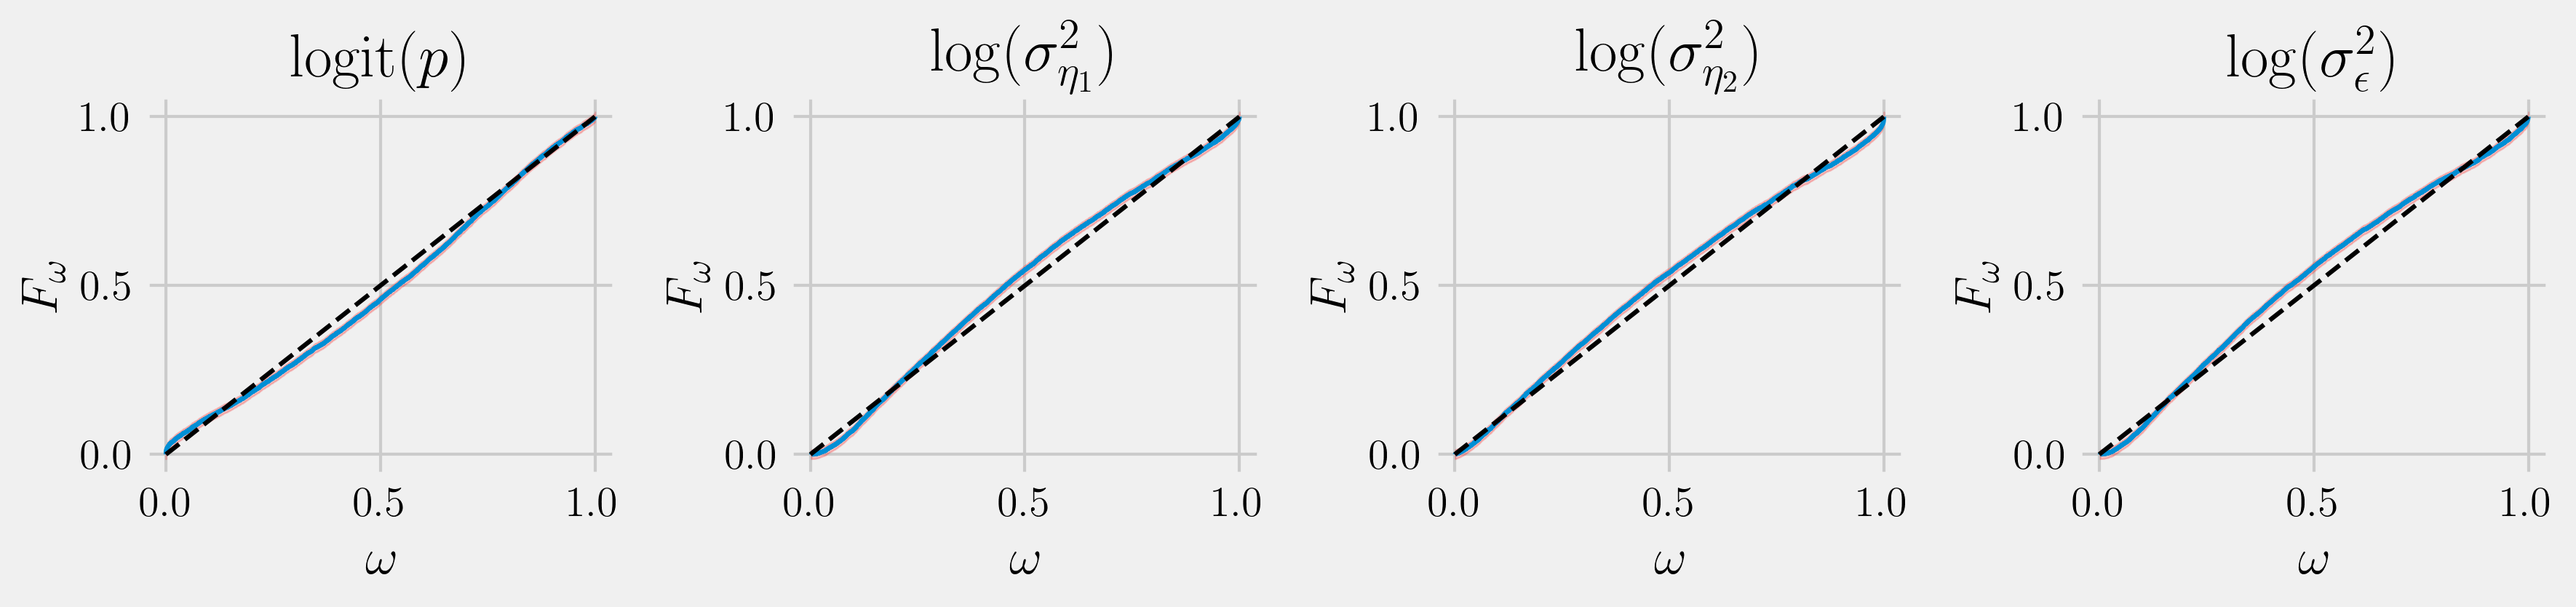

In [100]:
f = sbc_gaussian(gmmnet, prior, 10000, ecdf=True, ecdf_diff=False, logscale=[1,2,3])
#f.savefig(fname="figures/gmss_noisy_sbc.png", transparent=True, bbox_inches='tight')

In [ ]:
n_prior, n_obs, batchsize = 10000, 600, 10

# sample parameter values from the specified prior
Theta  =  prior.sample((n_prior,))

# draw samples from the simulator conditioned on parameter values
Y = gaussian_mixture(Theta, n_obs)

plt.hist(Y.var(dim=1).log10(), bins=25)
plt.xlabel(r'$\log_{10}(\mathrm{var}(Y))$')
plt.title('Observed variance plot')
plt.show()

### using sbi package

In [61]:
import sbi
from sbi import analysis as analysis
from sbi.inference.base import infer

In [85]:
# prior
class InverseGammaUniform():
    def __init__(self, params_p, params_sigma2_1, params_sigma2_2, params_sigma2_eps):
        self.params = {'p':params_p, 'sigma2_eta1':params_sigma2_1,
                       'sigma2_eta2':params_sigma2_2, 'sigma2_epsilon':params_sigma2_eps}
        
        self.p = D.Uniform(low=self.params['p']['lower'], 
                                             high=self.params['p']['upper'])
        
        self.sigma2_eta1 = D.InverseGamma(self.params['sigma2_eta1']['alpha'],
                                                                          self.params['sigma2_eta1']['beta'])
        
        self.sigma2_eta2 = D.InverseGamma(self.params['sigma2_eta2']['alpha'],
                                                                          self.params['sigma2_eta2']['beta'])
        
        self.sigma2_epsilon = D.InverseGamma(self.params['sigma2_epsilon']['alpha'],
                                                                          self.params['sigma2_epsilon']['beta'])
        
    def sample(self, shape: torch.Size = ()):
        theta = torch.stack([self.p.sample(shape),
                            self.sigma2_eta1.sample(shape),
                            self.sigma2_eta2.sample(shape),
                            self.sigma2_epsilon.sample(shape)
                            ], dim=-1)
        
        # transform parameters
        theta[...,0].logit_()
        theta[...,1:].log_()   
        
        return theta
    
    def log_prob(self, theta):
        logpdf = self.p.log_prob(theta[...,0].sigmoid()) + torch.log(abs(theta[...,0].sigmoid() * (1 - theta[...,0].sigmoid()))) +\
        self.sigma2_eta1.log_prob(theta[...,1].exp()) + torch.log(abs(theta[...,1].exp())) +\
        self.sigma2_eta2.log_prob(theta[...,2].exp()) + torch.log(abs(theta[...,2].exp())) +\
        self.sigma2_epsilon.log_prob(theta[...,3].exp()) + torch.log(abs(theta[...,3].exp()))

        return logpdf
        

prior_sbi = InverseGammaUniform(p, sigma2_1, sigma2_2, sigma2_eps)

# simulator
def simulator(theta: torch.Tensor, T=600) -> torch.Tensor:
    '''
    Simulates from a Gaussian mixture state-space model
    '''
    theta[...,0].sigmoid_()
    theta[...,1:].exp_()
    # simulate hidden state
    w = D.Bernoulli(probs=theta[...,0]).sample((T,)).T
    x = torch.zeros_like(w)

    x[...,0] = w[...,0] * D.Normal(torch.ones_like(theta[...,1]),
                                                      torch.sqrt(theta[...,1])).sample() +\
     (1 - w[...,0]) * D.Normal(torch.ones_like(theta[...,2]),
                                                  torch.sqrt(theta[...,2])).sample()
    
    for t in range(1,T):
        x[...,t] = w[...,t] * D.Normal(x[...,t-1], torch.sqrt(theta[...,1])).sample() +\
     (1 - w[...,t]) * D.Normal(x[...,t-1], torch.sqrt(theta[...,2])).sample()
    
    # simulate observables
    y = D.Normal(x.T, torch.sqrt(theta[...,3])).sample()

    return y.T        
    

In [86]:
x = prior_sbi.sample()
prior_sbi.log_prob(x)

tensor(-5.2047)

In [87]:
posterior = infer(simulator, prior_sbi, method='SNPE', num_simulations=1000)

c:\Users\joelp\anaconda3\envs\firstpaper\Lib\site-packages\sbi\utils\user_input_checks_utils.py:389: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
c:\Users\joelp\anaconda3\envs\firstpaper\Lib\site-packages\sbi\utils\user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
c:\Users\joelp\anaconda3\envs\firstpaper\Lib\site-packages\sbi\utils\user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(
Running 1000 simulations.: 100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]


 Neural network successfully converged after 54 epochs.

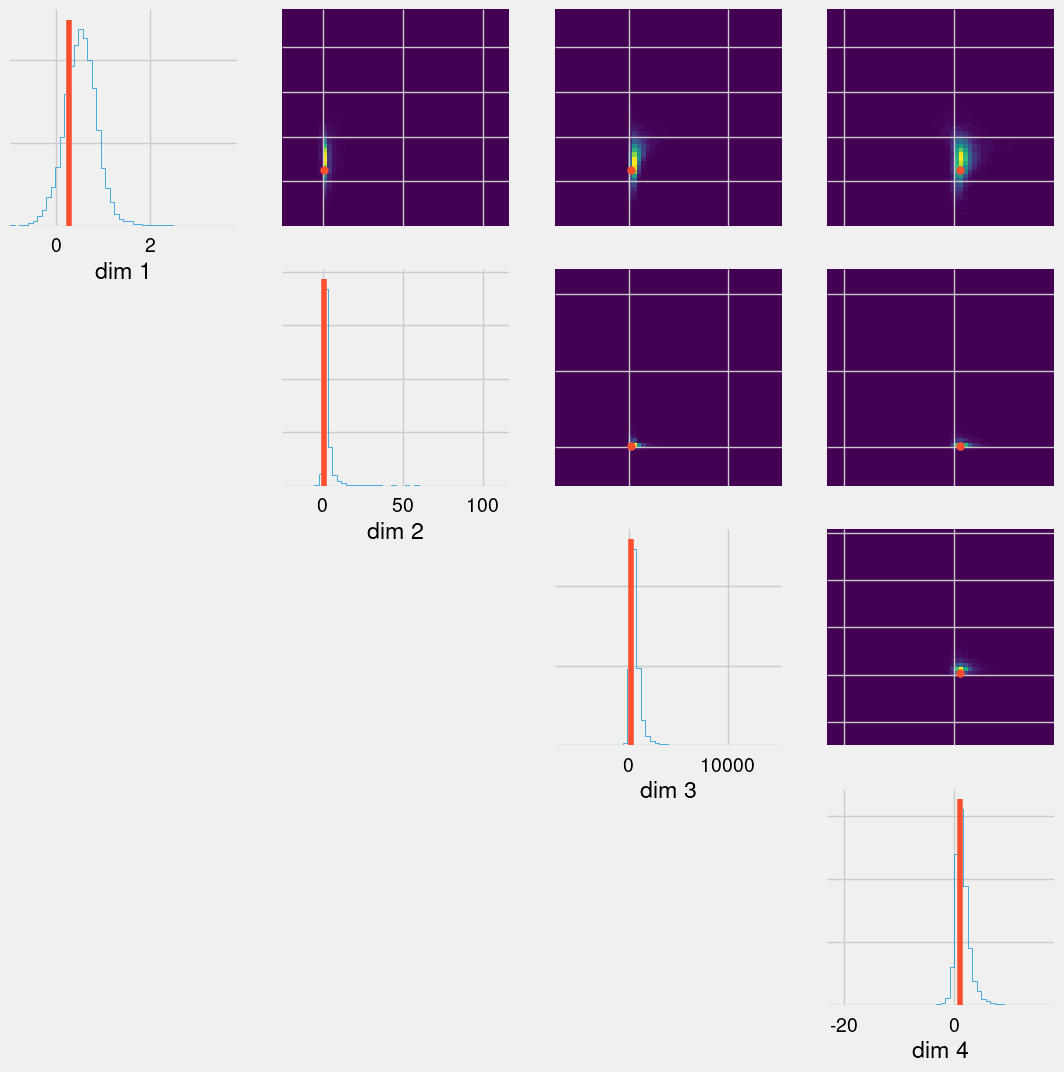

In [178]:
theta = prior_sbi.sample()
print(theta)
yobs = simulator(theta)
samples = posterior.sample((10000,), x=yobs)
_ = analysis.pairplot(samples,
                    points=theta,
                    figsize=(12,12))

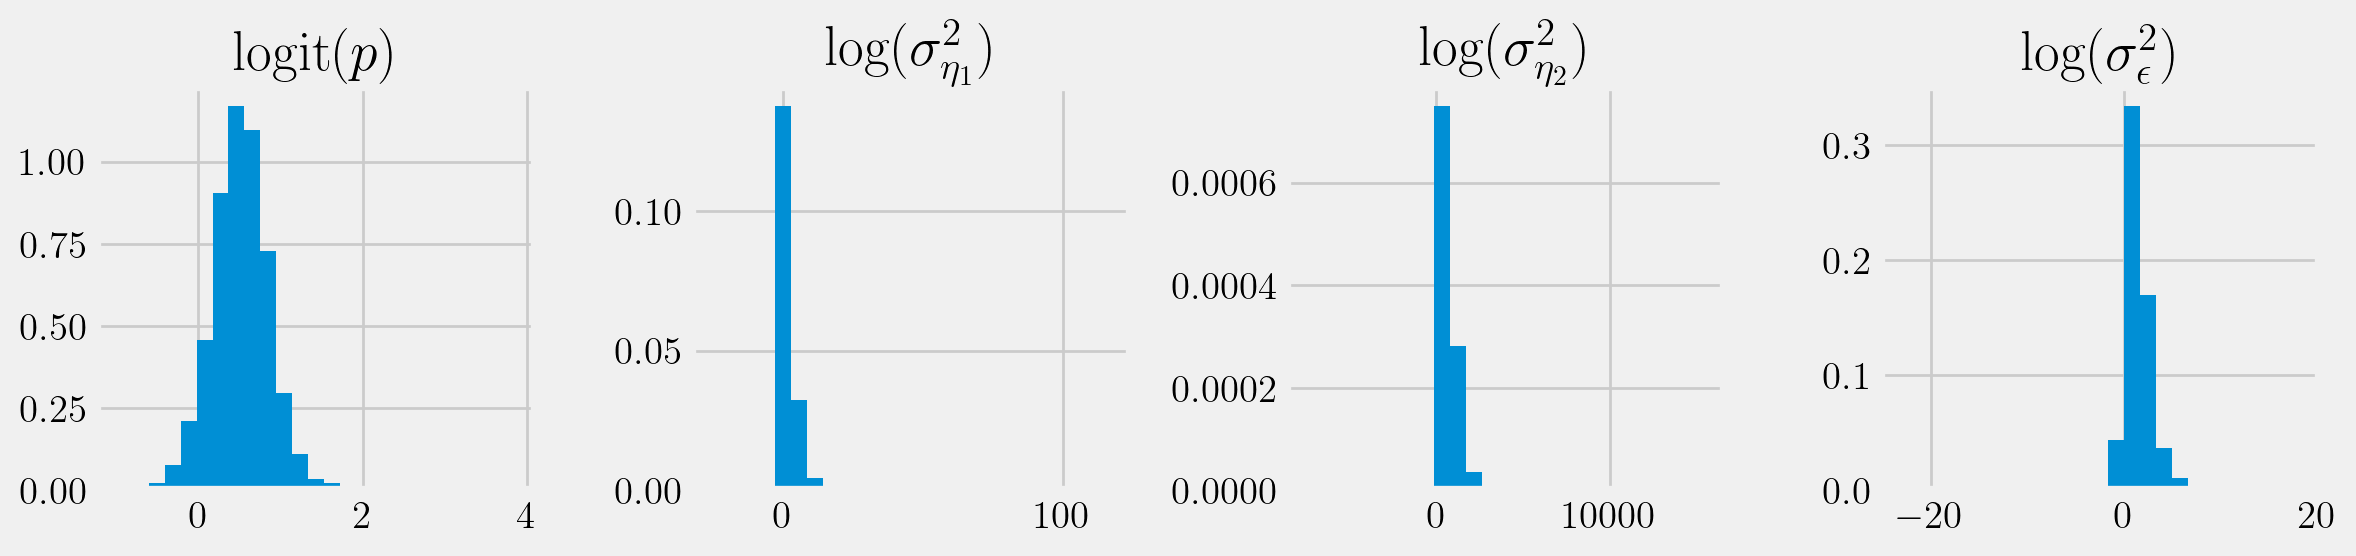

In [180]:
fig = plt.figure(figsize=(12, 3), dpi=200)

fig.add_subplot(141)
plt.hist(samples[...,0], bins=25, density=True)
plt.title(r'$\mathrm{logit}(p)$')

fig.add_subplot(142)
plt.hist(samples[...,1], bins=25, density=True)
plt.title(r'$\log(\sigma_{\eta_1}^2) $')

fig.add_subplot(143)
plt.hist(samples[...,2], bins=25, density=True)
plt.title(r'$\log(\sigma_{\eta_2}^2) $')

fig.add_subplot(144)
plt.hist(samples[...,3], bins=25, density=True)
plt.title(r'$\log(\sigma_{\epsilon}^2) $')

plt.tight_layout()
plt.show()